# Libraries

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import pretty_midi
import pygame
import os
import pickle

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


In [3]:
def flatten(x):
    return [item for sublist in x for item in sublist]

# Piano Roll to MIDI

In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=20, program=0):
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

# Read midi files

In [4]:
def get_all_songs_paths(base_dir):
    artist_directories = [
        base_dir + x for x in os.listdir(base_dir)
        if x != '.DS_Store' and x != 'xmas'
    ]
    return flatten([[
        path + "/" + x for x in os.listdir(path) if x.endswith("format0.mid")
    ] for path in artist_directories])

In [5]:
path = "../data/clean/midi_files_beethoven.p"
base_dir = "../data/raw/beethoven/"
rerun = False

if not os.path.isfile(path) or rerun:
    midi_files = []
    for path in os.listdir(base_dir):
        logger.info("Read " + path + " file.")
        try:
            midi_files.append(pretty_midi.PrettyMIDI(base_dir + path))
        except:
            logger.warning(path + " impossible to read.")
    pickle.dump(midi_files, open("../data/clean/midi_files.p", "wb"))
else:
    midi_files = pickle.load(open("../data/clean/midi_files.p", "rb"))
logger.info(str(len(midi_files)) + " midi files.")

# Test of simplication

In [6]:
path = "../data/temp/temp.mid"
pygame.init()

(6, 0)

## Test frequency sampling

In [7]:
piano_roll_20 = midi_files[0].get_piano_roll(20)[:,:200]
piano_roll_to_pretty_midi(piano_roll_20, 20).write(path)
pygame.mixer.music.load(path)
pygame.mixer.music.play()

In [8]:
piano_roll_5 = midi_files[0].get_piano_roll(5)[:,:50]
piano_roll_to_pretty_midi(piano_roll_5, 5).write(path)
pygame.mixer.music.load(path)
pygame.mixer.music.play()

** not a huge difference => fs = 5 => smaller data (easier training) **

## Test pitch

Test if song is really different we take only one note at a time

In [9]:
def get_only_max(x):
    y = np.zeros(len(x))
    maximum = x.max()
    y[np.argmax(x)] = maximum
    return y

x = np.array([0, 1, 1, 2, 3, 2, 1, 3, 1])
get_only_max(x)

array([0., 0., 0., 0., 3., 0., 0., 0., 0.])

In [10]:
piano_roll_5_max = np.apply_along_axis(get_only_max, 0, piano_roll_5)

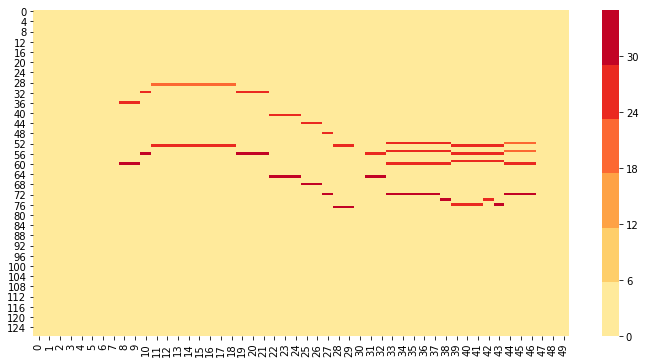

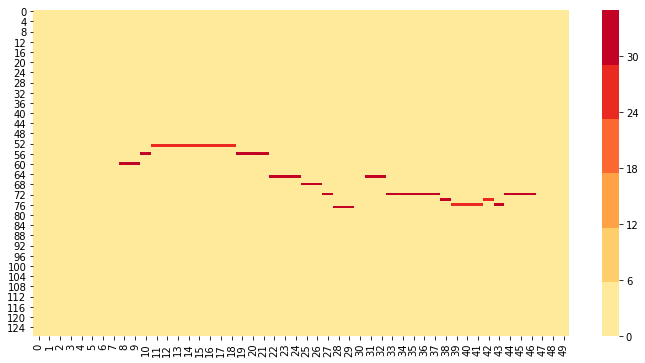

In [11]:
plt.subplots(figsize=(12,6))
sns.heatmap(piano_roll_5, cmap = sns.color_palette("YlOrRd"))
plt.title("Piano Roll with all notes (fs=5)")
plt.show()
plt.subplots(figsize=(12,6))
sns.heatmap(piano_roll_5_max, cmap = sns.color_palette("YlOrRd"))
plt.title("Piano Roll with only maximum note (fs=5)")
plt.show()

In [12]:
piano_roll_to_pretty_midi(piano_roll_5, 5).write(path)
pygame.mixer.music.load(path)
pygame.mixer.music.play()

In [13]:
piano_roll_to_pretty_midi(piano_roll_5_max, 5).write(path)
pygame.mixer.music.load(path)
pygame.mixer.music.play()

** Not a big difference we will use a the max pitch to get only one note at the same time**

# MIDI to simplified sequence of notes

In [14]:
fs = 5

In [15]:
def get_simplify_piano_roll(midi_file, fs=5):
    x = midi_file.get_piano_roll(fs)
    y = np.apply_along_axis(np.argmax, 0, x)
    # if note not played => -1
    y[np.apply_along_axis(np.max, 0, x) == 0] = -1
    return y

In [16]:
songs_piano_roll = [get_simplify_piano_roll(x, fs) for x in midi_files]

In [17]:
# Map note to integer from 0 to number of total notes
all_notes = set(flatten([set(x) for x in songs_piano_roll]))
note_to_int = dict((note, number) for number, note in enumerate(all_notes))

In [18]:
def mapping(song, note_to_int):
    return [note_to_int[note] for note in song]

songs_piano_roll = [mapping(song, note_to_int) for song in songs_piano_roll]

# Prepare X, y

In [25]:
def split_song(song, song_length, shift):
    # we put a shift argument to avoid repetitive pattern in our data
    X = list()
    y = list()
    for i in range(len(song) - song_length - 1):
        if ((i % shift) == 0):
            X.append(song[i:(i + song_length)])
            y.append(song[(i + 1 + song_length)])
    return X, y

In [26]:
# choose a duration (in seconds)
duration = 30
song_length = duration * fs

In [27]:
X_y = [split_song(song, song_length, 5) for song in songs_piano_roll]

X = flatten([X for X, y in X_y])
y = flatten([y for X, y in X_y])

X = np.stack(X)
print(X.shape)

# Reshape for keras LSTM input
n_patterns = len(X)
X = np.reshape(X, (n_patterns, song_length, 1))
print(X.shape)

# Scale X
X = X / float(len(all_notes))

y = np.stack(y)
print(y.shape)

# Convert to categorical
y = to_categorical(y)
print(y.shape)

(20156, 150)
(20156, 150, 1)
(20156,)


# Model

In [29]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(len(all_notes)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [30]:
filepath = "../data/temp/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(X, y, epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/1
20156/20156 [==============================] - 213s 11ms/step - loss: 3.9132


# Predict

In [142]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def predict_note(X):
    return sample(model.predict(np.reshape(X, (1, 150, 1)))[0])


int_to_notes = {value: key for (key, value) in note_to_int.items()}


def convert_note_to_original(note):
    return int_to_notes[note]


def generate_song(base_song, length=10):
    x = base_song
    y = []
    for i in range(length):
        y.append(predict_note(x))
        x = np.append(x, y[-1] / float(len(all_notes)))[1:]
    return [convert_note_to_original(note) for note in y]


def generated_song_to_piano_roll(generated_song):
    generated_piano_roll = np.zeros((128, len(generated_song)))
    for i, note in enumerate(generated_song):
        if note != -1:
            generated_piano_roll[note, i] = 30
    return generated_piano_roll

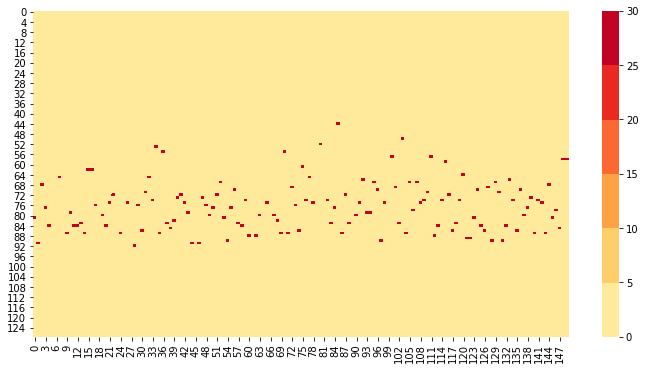

In [145]:
generated_song = generate_song(X[0], 150)
generated_piano_roll = generated_song_to_piano_roll(generated_song)

plt.subplots(figsize=(12, 6))
sns.heatmap(generated_piano_roll, cmap=sns.color_palette("YlOrRd"))
plt.show()

path = "../data/temp/temp.mid"
piano_roll_to_pretty_midi(generated_piano_roll, fs=fs).write(path)
pygame.mixer.music.load(path)
pygame.mixer.music.play()